<a href="https://colab.research.google.com/github/skhetrapal/chaotic_pde_fno/blob/main/ks_fno2d_m24_w64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
import warnings

warnings.filterwarnings('ignore')

def is_running_on_colab():
    return 'COLAB_GPU' in os.environ

# Use the function to check
if is_running_on_colab():
    print("This notebook is running on Google Colab.")

    # Mount your Google Drive.
    drive.mount("/content/drive")

This notebook is running on Google Colab.
Mounted at /content/drive


In [ ]:
!pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.

In [ ]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab data/FNO2d_module')


from fno2d import FNO2d

import torch
from trainer import Trainer
from utils import utilities, transforms
from dataloader import *
from loader_2d import *
from utils.utilities import set_seed
import argparse
#########################################################################

############### Setting the Device and Random SEED ######################
parser = argparse.ArgumentParser()
parser.add_argument("--seed", default=0, help = "Input Experiment Random Seed")

args = parser.parse_args(args = [])
random_seed = args.seed
set_seed(random_seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#########################################################################

################## Creating the Models ##################################

models = {
 'FNO': FNO2d(modes1=24, modes2=24, width=64).to(device),
}

#########################################################################

###################### Dataset Params ###################################

PATH = '/content/drive/MyDrive/Colab data/FNO2d_module/kuramoto_sivashinsky_data.npy'
training_data_resolution = 128
grid_size = 128
batch_size = 20
ntrain = 80
nval = 20
ntest = 20

#########################################################################

##################### Generate Data-Loaders #############################

loader = npzloader(path=PATH)

x_train, y_train, x_val, y_val, x_test, y_test = loader.split(ntrain, nval, ntest)

x_normalizer = utilities.UnitGaussianNormalizer(x_train)
y_normalizer = utilities.UnitGaussianNormalizer(y_train)

# train loader obj
train_obj = DataLoader_2D(X=x_train, y=y_train, n=ntrain, res=training_data_resolution, \
                            grid_size=grid_size, batch_size=batch_size, x_normalizer=x_normalizer)

# val loader obj
val_obj = DataLoader_2D(X=x_val, y=y_val, n=nval, res=training_data_resolution, \
                          grid_size=grid_size, batch_size=batch_size, x_normalizer=x_normalizer)

# test loader obj
test_obj = DataLoader_2D(X=x_test, y=y_test, n=ntest, res=training_data_resolution, \
                           grid_size=grid_size, batch_size=batch_size, x_normalizer=x_normalizer)

# dataloaders with grid info
train_grid_loader = train_obj.get_grid_loader()
val_grid_loader = val_obj.get_grid_loader()
test_grid_loader = test_obj.get_grid_loader()

#########################################################################

################## HyperParameters for Training #########################

hyperparameters = {
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'step_size': 100,
    'gamma': 0.5,
    'optimizer': 'Adam',
    'scheduler': 'StepLR',
    'loss_fn': 'RelL2',
    'loss_metric': 'MSE',
    'batch_size': batch_size,
    'random_seed': random_seed,
}

#########################################################################

############# Create the Trainer, Fit Dataset and Test ##################

out_transform = transforms.OutTransforms(y_normalizer, device=device).stdTransform

for model_name in models:
    model = models[model_name]
    trainer = Trainer(model_name=f"Model+{model_name}+KS", model=model, hyperparams=hyperparameters, \
                    output_transform=out_transform, device=device)
    trainer.fit(train_dataloader=train_grid_loader, val_dataloader=val_grid_loader, test_dataloader=test_grid_loader)

#########################################################################

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Random SEED set as 0


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Number of Parameters in the Model: 18899713
optimizer: Adam, scheduler: StepLR
loss_fn: RelL2, test_loss_metric: MSE
Initial_LR: 0.001, weight_decay: 0.0001
Epoch := 1 || Time (sec):= 6.9461  || Train Loss := 9.182e-01 || Validation Loss := 9.214e-01
Epoch := 2 || Time (sec):= 1.1845  || Train Loss := 8.945e-01 || Validation Loss := 8.727e-01
Epoch := 3 || Time (sec):= 1.1269  || Train Loss := 8.187e-01 || Validation Loss := 7.431e-01
Epoch := 4 || Time (sec):= 1.1512  || Train Loss := 6.509e-01 || Validation Loss := 5.514e-01
Epoch := 5 || Time (sec):= 3.4547  || Train Loss := 4.837e-01 || Validation Loss := 4.295e-01
Epoch := 6 || Time (sec):= 1.3014  || Train Loss := 4.045e-01 || Validation Loss := 4.176e-01
Epoch := 7 || Time (sec):= 1.4823  || Train Loss := 3.844e-01 || Validation Loss := 3.878e-01
Epoch := 8 || Time (sec):= 1.8207  || Train Loss := 3.679e-01 || Validation Loss := 3.857e-01
Epoch := 9 || Time (sec):= 1.1159  || Train Loss := 3.615e-01 || Validation Loss := 3.728e-

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
Initial_LR,▁
Num_Params,▁
Random_SEED,▁
Time,█▁▁▁▄▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_epochs,▁
Train Loss,█▇▆▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▆▆▅▅▅▄▂▂▃▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▃▁▁▁▂
weight_decay,▁
Epoch,92
Initial_LR,0.001


In [ ]:
########### Run the above model on trained data #######################

# Load the trained model's state dictionary
model_path = '/content/models_state_dict/Model+FNO+KS0.00120/model.pt'  # Replace with the actual path
state_dict = torch.load(model_path)

# Create an instance of the model
from fno2d import FNO2d
model = FNO2d(modes1=24, modes2=24, width=64)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Get a batch of data from the test set
for batch in test_grid_loader:
    x, y = batch
    break

# Perform inference
with torch.no_grad():
    output = model(x)

#Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([20, 128, 128, 1])


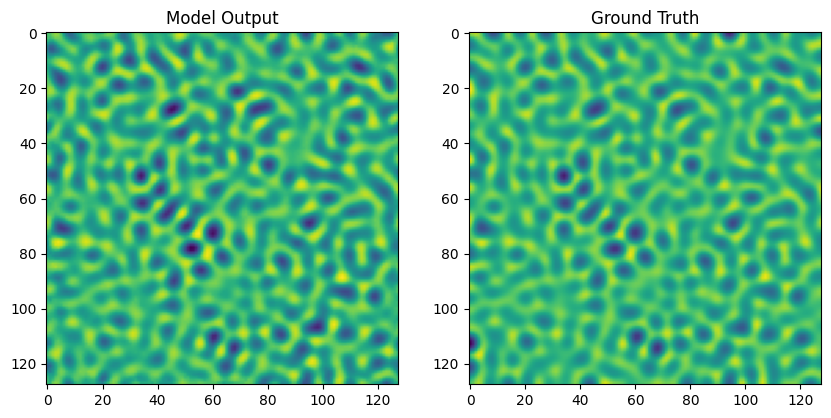

In [ ]:
####### Plot of trained model 'output' and 'y' from test data

import matplotlib.pyplot as plt

# Assuming output and y are tensors of shape (batch_size, channels, height, width)
# First image from the batch

output_image = output[0, :, :, 0].cpu().numpy()
y_image = y[0, 0, :, :].cpu().numpy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the model's output
axes[0].imshow(output_image)
axes[0].set_title("Model Output")

# Plot the ground truth
axes[1].imshow(y_image)
axes[1].set_title("Ground Truth")

plt.show()
